In [2]:
%run libreria.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utm
import pandas as pd
import math
from matplotlib.pyplot import figure
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pymysql

def distancia_genetica_corregida(a, b, distribution, N_mam=269):
    P_A1_a1=1
    P_A2_a2=1
    P_A2_a2_hermano_a2=1
    for alele in distribution:
        P_A1_a1=P_A1_a1*(distribution[alele][a[alele]])
        P_A2_a2=P_A2_a2*(distribution[alele][b[alele]])
        # La probabilidad abajo es: si son iguales, es 1/2 (si vino de la misma columna alelo) + (1/2)*prob_del_alelo si vino de distinta columna, pero si 
        # son distintos son 1/2 * probabilidad de ese alelo. 
        P_A2_a2_hermano_a2=P_A2_a2_hermano_a2*((1/2)*int(a[alele]==b[alele])+(1/2)*distribution[alele][b[alele]])
    P_A1_A2_distinta_mama=P_A1_a1*P_A2_a2
    P_A1_A2_misma_mama=P_A1_a1*P_A2_a2_hermano_a2
    return (1/(1+(N_mam-1)*P_A1_A2_distinta_mama/P_A1_A2_misma_mama))
    

def get_connection():
    return pymysql.connect(host='ec2-18-222-185-142.us-east-2.compute.amazonaws.com',
                             user='root',
                             password='password',
                             db='dbname',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
        
    
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where batchname like \"%cathcmentSYD2018%\" "
    cursor.execute(sql)
    res=cursor.fetchall()
connection.close()



curvas=pd.DataFrame(res)

curvas["bootstrap"]=[eval(aa)["bootstrap"] for aa in curvas["task_params"]]
curvas["N_mam"]=[eval(aa)["N_mam"] for aa in curvas["task_params"]]
curvas["urban"]=[eval(aa)["urban"] for aa in curvas["task_params"]]
curvas["rural"]=[eval(aa)["rural"] for aa in curvas["task_params"]]
curvas["min_dist"]=[eval(aa).get("min_dist", 1) for aa in curvas["task_params"]]
curvas["lambda"]=[eval(aa)["params"]["lambd"] for aa in curvas["task_params"]]
curvas["exp_mean"]=1/curvas["lambda"]




In [3]:
list(curvas["task_params"])[-3]

'{"num_abejas":3000, "bootstrap":97, "randomfun":random.expovariate, "params":{"lambd":0.233}, "d2":d2, "min_dist":0.4, "N_mam":600, "urban":True, "rural":True, "weird_coords":True, "year":2018, "distance_cert":False, "margin":10}'

In [5]:
takss=list(set(curvas["task_id"]))

In [6]:
connection=get_connection()

with connection.cursor() as cursor:
    sql="select distinct task_id, total from familias_abejas_conteo where task_id in ("+", ".join([str(j) for j in takss])+")"
    cursor.execute(sql)
    res=cursor.fetchall()
connection.close()



In [7]:
finn=curvas.set_index("task_id").join(pd.DataFrame(res).set_index("task_id"))

In [8]:
len(curvas)

4500

In [9]:
len(curvas)

4500

In [10]:
set(finn["exp_mean"])

{0.1,
 0.4,
 0.6997900629811057,
 1.0,
 1.3003901170351104,
 1.6,
 1.9011406844106462,
 2.1978021978021975,
 2.5,
 2.801120448179272,
 3.095975232198142,
 3.4013605442176873,
 3.7037037037037033,
 4.0,
 4.291845493562231}

In [14]:
%run libreria.py

In [18]:
starttime=time.time()
    
#get basic information and variables

urban_coords=[]
rural_coords=[]
locations, coordenadas, distance_national_park=get_loc_coords_dnp()
other_coords=["Lindfield", "Gordon", "Stives"]

tot_abejas=480


urban=True
rural=True

xaxis  = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[0]  for l in coordenadas]
yaxis =  [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[1] for l in coordenadas]
medy  =  np.mean(yaxis)
medx  =  np.mean(xaxis)

xaxis  = [to_xy((coordenadas[l][0],coordenadas[l][1]))[0]  for l in coordenadas]
yaxis = [to_xy((coordenadas[l][0],coordenadas[l][1]))[1] for l in coordenadas]
medy2  =  np.mean(yaxis)
medx2  =  np.mean(xaxis)

information={}



for k in coordenadas:
    if True:
        information[k]={}
        information[k]["coordenadas"]=coordenadas[k]
        utm_val=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
        information[k]["utm_xy_or"]=utm_val
        information[k]["utm_xy"]=((utm_val[0]-medx)/1000, (utm_val[1]-medy)/1000)
        xy_val=to_xy(coordenadas[k])
        information[k]["alt_xy"]=((xy_val[0]-medx2)/1000, (xy_val[1]-medy2)/1000)


list_cor=list(pd.DataFrame(information ).loc["utm_xy"])
list_cor_keys=list(pd.DataFrame(information).transpose().index)
utm_xs=[i[0] for i in list_cor]
utm_ys=[i[1] for i in list_cor]
around=20
xs_max=np.max(utm_xs)+around
xs_min=np.min(utm_xs)-around
ys_max=np.max(utm_ys)+around
ys_min=np.min(utm_ys)-around


In [20]:
xs_max_tr=xs_max*1000+medx
xs_min_tr=xs_min*1000+medx
ys_max_tr=ys_max*1000+medy
ys_min_tr=ys_min*1000+medy

corners=[[xs_max_tr, ys_max_tr], [xs_max_tr, ys_min_tr], [xs_min_tr, ys_min_tr], [xs_min_tr, ys_max_tr]]
ncors=[]
for cor in corners:
    ncors.append(utm.to_latlon(cor[0], cor[1], 56, "H"))
    
ncors.append(ncors[0])

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


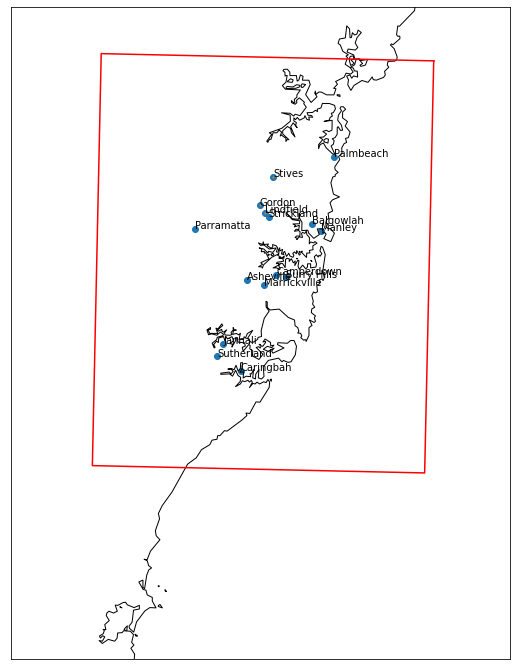

In [25]:

plt.figure(figsize=(12,12))

# Lambert Conformal Conic map.
m = Basemap(llcrnrlon=150.6,llcrnrlat=-34.591003504203526,
            urcrnrlon=151.7,
            urcrnrlat=-33.391003504203526,
            projection='lcc',lat_1=-33.491003504203526,lat_2=-39.235773685145425,lon_0=150.78201521493236,
            resolution ='h',area_thresh=0.0000005)
# read shapefile.



m.drawcoastlines()
m.drawcountries()
m.drawrivers()

x, y = m([k[1] for k in ncors], [k[0] for k in ncors])
plt.plot(x, y, color="red")

x, y = m([information[p]["coordenadas"][1] for p in information], [information[p]["coordenadas"][0] for p in information])
plt.scatter(x, y)
for xx, yy, s in zip(x, y, list(information.keys())):
    plt.text(xx, yy, s)

kurigngai=["Stives", "Gordon", "Lindfield"]
x, y = m([information[p]["coordenadas"][1] for p in kurigngai], [information[p]["coordenadas"][0] for p in kurigngai])
plt.scatter(x, y, s=1)
plt.savefig("mapColonies.pdf")

    

In [26]:
def gen_distancias_proba(seed, xs_min, ys_min, r1, r2, randomfun, params, num_abejas, pi2,  list_cor, min_dist_2, distribution, medx, medy, d2, year):
	locs=[]
	distancias=[]
	
	rmom1=rsel(distribution)
	rmom2=rsel(distribution)
	letter="H"
	if year=="QL": letter="J"
	
	random.seed(seed+5676)
	land=False
	errors=0
	corrects=0
	while corrects<10:
		loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
		land=(not consult_loc(loc_familia, medx, medy, d2, letter))
		corrects+=land
	
	if corrects<3 and "bm" in d2:
		errors=0
		locs_familia=[]
		for k in range(3000):
			loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
			locs_familia.append(loc_familia)
		while (not batch_upload(locs_familia, medx, medy, d2, letter)): 
			locs_familia=[]
			for k in range(3000):
				loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
				locs_familia.append(loc_familia)
			
	random.seed(seed+5676)
	land=False
	while land==False:
		loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
		land=(not consult_loc(loc_familia, medx, medy, d2, letter))
		
	
	return locs, loc_familia

In [29]:
list_cor=list(pd.DataFrame(information ).loc["utm_xy"])
list_cor_keys=list(pd.DataFrame(information).transpose().index)
utm_xs=[i[0] for i in list_cor]
utm_ys=[i[1] for i in list_cor]
xs_max=np.max(utm_xs)+around
xs_min=np.min(utm_xs)-around
ys_max=np.max(utm_ys)+around
min_dist=100
ys_min=np.min(utm_ys)-around
print("Min dist "+str(min_dist))
for k in range(len(list_cor)-1):
    for j in range(k+1, len(list_cor)):
        a=euclidean_dist(list_cor[k], list_cor[j])
        if a<min_dist: 
            min_dist=a
print("Min dist "+str(min_dist))

start=time.time()
min_dist_2=min_dist/2
pi2=2*math.pi
r1=(xs_max-xs_min)
r2=(ys_max-ys_min)

Min dist 100
Min dist 1.0993310318970086


In [30]:
def get_d2():
	connection=get_connection()
	with connection.cursor() as cursor:
		cursor.execute("select * from onwater_results where letter=\"J\"")
		res=cursor.fetchall()
	connection.close()
	d2j={}
	for s in res:
		d2j[(round(s["longitud"], 3), round(s["latitud"], 4))]=s["onwater"]
		
	connection=get_connection()
	with connection.cursor() as cursor:
		cursor.execute("select * from onwater_results where letter=\"H\"")
		res=cursor.fetchall()
	connection.close()
	d2h={}
	for s in res:
		d2h[(round(s["longitud"], 3), round(s["latitud"], 4))]=s["onwater"]
		
	return {"J":d2j, "H":d2h}


d2=get_d2()


In [33]:
als={56:0.3, 57:0.3, 50:0.4}
distribution={"A1":als, "A2":als, "A3":als, "A4":als, "A5":als, "A6":als, "A7":als}

In [37]:
%run libreria2.py

In [53]:
bootstrap=10
seed=100
randomfun=random.expovariate
params={"lambd":1/2.5}
num_abejas=3000
year=2018
locs_familias=[]
fams=0
seed=2250
while fams<600:
    print(fams/600, end="       \r")
    a, loc= gen_distancias_proba(5676+bootstrap*100000+seed, xs_min=xs_min, ys_min=ys_min, r1=r1, r2=r2, 
                    randomfun=randomfun, params=params,num_abejas=num_abejas, pi2=pi2, list_cor=list_cor, 
                    min_dist_2=min_dist_2, distribution=distribution, medx=medx, medy=medy , d2=d2, year=year)
    locs_familias.append(loc)
    if len(a)>0: fams+=1
    #print(len(a))
    seed+=1

In [57]:
seed-2250

1419

In [54]:
locs_familias_correct=[]
for loc in locs_familias:

    xs_max_tr=loc[0]*1000+medx
    ys_max_tr=loc[1]*1000+medy

    locs_familias_correct.append(utm.to_latlon(xs_max_tr, ys_max_tr, 56, "H"))


In [ ]:
newnames={'Bondi Junction-17':'S17-7', 'Leichhardt-17':'S17-13',
          'Vegetable university-17':'S17-5','Marrickville-17':"S17-3", 'Marrickville 2-17':'S17-4',
          'Paddington-17':"S17-6",  'Jannali-17':"S17-2", 'Caringbah-17':"S17-1", 
          'Anandale-17':'S17-14', 'Beerwah2':"Q-4",  'Surrey Hills-17':'S17-12',
          'Tanya-17':'S17-8','Newtown-17':'S17-9','University-17':'S17-10',
          'Marrickville sp-17':'Marrickville sp-17','Beerwah3':"Q-5", "Beerwah1":"Q-1", "Saharafarms":"Q-2", 
          "Mololahvalley":"Q-3", "Balgowlah ":"S-1", "Manley":"S-2", "Surry Hills":"S-3",
          "Asheville":"S-4", "Camperdown":"S-5", "Marrickville":"S-6", "Caringbah":"S-7", 
          "Gordon":"S-8", "Lindfield":"S-9", "Palmbeach":"S-10", "Stives":"S-11", "Sutherland":"S-12", 
          "Jannali":"S-13", 'Strickland':"S-24", 'Parramatta':"S-22"}


In [79]:
dicton={'Marrickville':"6", 'Surry Hills':"3", 'Camperdown':"5", 'Asheville':"4", 'Balgowlah ':"1", 'Manley':"2",
        'Jannali':"13", 'Sutherland':"12", 'Stives':"11", 'Palmbeach':"10", 'Lindfield':"9", 'Gordon':"8",
        'Caringbah':"7", 'Parramatta':"22", 'Strickland':"24"}



In [69]:
information.keys()

dict_keys(['Marrickville', 'Surry Hills', 'Camperdown', 'Asheville', 'Balgowlah ', 'Manley', 'Jannali', 'Sutherland', 'Stives', 'Palmbeach', 'Lindfield', 'Gordon', 'Caringbah', 'Parramatta', 'Strickland'])

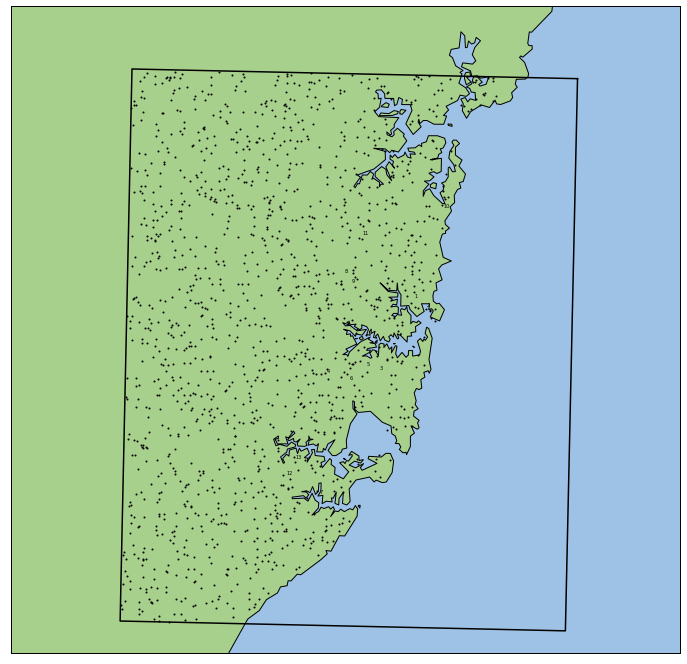

In [100]:

plt.figure(figsize=(12,12))

# Lambert Conformal Conic map.
m = Basemap(llcrnrlon=150.6,llcrnrlat=-34.591003504203526,
            urcrnrlon=151.7,
            urcrnrlat=-33.391003504203526,
            projection='lcc',lat_1=-33.491003504203526,lat_2=-39.235773685145425,lon_0=150.78201521493236,
            resolution ='h',area_thresh=0.0000005)
# read shapefile.

m.fillcontinents(color='#a8d08d')
m.drawmapboundary(fill_color='#9dc2e5')
m.drawcoastlines()
m.drawcountries()
m.drawrivers()

x, y = m([k[1] for k in ncors], [k[0] for k in ncors])
plt.plot(x, y, color="black")



x, y = m([k[1] for k in locs_familias_correct], [k[0] for k in locs_familias_correct])
plt.scatter(x, y, color="black", s=1, zorder=100)




#xs=[information[p]["coordenadas"][1] for p in information]
#ys=[information[p]["coordenadas"][0] for p in information]

xs=[]
ys=[]
for p in information:
    if  dicton[p]!="22" and  dicton[p]!="24":
        xs.append(information[p]["coordenadas"][1])
        ys.append(information[p]["coordenadas"][0])
x, y = m(xs, ys)
#plt.scatter(x, y, zorder=100, color="yellow", s=500, edgecolor="black")
ajuste=500
for xx, yy, s in zip(x, y, list(information.keys())):
    if  dicton[s]!="22" and  dicton[s]!="24":
        ajuste2=0
        ajuste3=0
        if dicton[s]=="3" or dicton[s]=="9": ajuste2=300
        if  dicton[s]=="9": ajuste3=-1400
        #plt.text(xx-ajuste+ajuste2, yy+ajuste3, dicton[s], zorder=1000)
        plt.text(xx, yy, dicton[s], zorder=1000,fontdict={"size":5} )

kurigngai=["Stives", "Gordon", "Lindfield"]
x, y = m([information[p]["coordenadas"][1] for p in kurigngai], [information[p]["coordenadas"][0] for p in kurigngai])
#plt.scatter(x, y, s=1)
plt.ylim(2.6*13299, 132994.10941386316)
plt.savefig("mapColonies.pdf")


In [103]:
kurigngai=["Stives", "Gordon", "Lindfield"]
x, y = m([information[p]["coordenadas"][1] for p in kurigngai], [information[p]["coordenadas"][0] for p in kurigngai])


In [107]:
for k in kurigngai:
    for p in kurigngai:
        a, b, _, _ = information[k]["utm_xy_or"]
        aa, bb, _, _ = information[p]["utm_xy_or"]
        distance=((a-aa)**2+(b-bb)**2)**0.5
        print(distance)

0.0
6363.502276682256
7381.464353563819
6363.502276682256
0.0
1857.7738274709718
7381.464353563819
1857.7738274709718
0.0


In [ ]:
1857

In [111]:
3*1*math.pi*8

75.39822368615503

In [51]:
def gen_proportion_land_square(seed, xs_min, ys_min, r1, r2, randomfun, params, num_abejas, pi2,  list_cor, min_dist_2, distribution, medx, medy, d2, year):
    locs=[]
    distancias=[]

    rmom1=rsel(distribution)
    rmom2=rsel(distribution)
    letter="H"
    if year=="QL": letter="J"

    random.seed(seed+5676)
    land=False
    errors=0
    corrects=0
    while corrects<10:
        loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
        land=(not consult_loc(loc_familia, medx, medy, d2, letter))
        corrects+=land

    if corrects<3 and "bm" in d2:
        errors=0
        locs_familia=[]
        for k in range(3000):
            loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
            locs_familia.append(loc_familia)
        while (not batch_upload(locs_familia, medx, medy, d2, letter)): 
            locs_familia=[]
            for k in range(3000):
                loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
                locs_familia.append(loc_familia)

    random.seed(seed+5676)
    land=False
    landpoints=0
    totiter=10000
    for k in range(totiter):
        loc_familia=(xs_min+random.random()*r1, ys_min+random.random()*r2)
        land=(not consult_loc(loc_familia, medx, medy, d2, letter))
        if land==True: landpoints+=1


    return landpoints/totiter

In [52]:
gen_proportion_land_square(seed, xs_min, ys_min, r1, r2, randomfun, params, num_abejas, pi2,  list_cor, min_dist_2, distribution, medx, medy, d2, year)


0.7296

In [53]:
r1*r2


2014.2246451317415

In [54]:
total_land_area = 0.7296*r1*r2

In [55]:
total_land_area

1469.5783010881187

In [56]:
2250*86 / total_land_area

131.67042535721095

In [57]:
total_land_area*750/86

12816.089835070801

In [64]:
plt.figure(figsize=(10, 10))
nmins=sorted(list(set(finn["min_dist"])))
for nmin in nmins:
    fami=finn[(finn.min_dist==nmin)]
    xs=sorted(list(set(fami["exp_mean"])))
    ys=[]
    for x in xs:
        ys.append(( fami[fami.exp_mean==x]["total"].mean() )*86/total_land_area)
    plt.plot(xs, ys, label=str(int(nmin*1000/2))+"m")
    
plt.legend(title="Catchment area")
plt.ylabel("Minimum number of colonies in Kuringbai")
plt.xlabel("Mean flight of male bee")
plt.plot([-10, 100], [750, 750], color="red")
plt.xlim([0, 5])
#plt.ylim([0,6000])
plt.yscale("log")
plt.savefig("colonies_by_flight.pdf")


In [ ]:
100*

In [25]:
information.keys()

dict_keys(['Marrickville', 'Surry Hills', 'Camperdown', 'Asheville', 'Balgowlah ', 'Manley', 'Jannali', 'Sutherland', 'Stives', 'Palmbeach', 'Lindfield', 'Gordon', 'Caringbah', 'Parramatta', 'Strickland'])

In [46]:
ncors

[(-33.491003504203526, 151.53249524349738),
 (-34.24690062649693, 151.51950041103092),
 (-34.235773685145425, 150.78201521493236),
 (-33.48018752375011, 150.80147254288337)]

In [24]:
sorted(list(set(finn[(finn["min_dist"]==1)]["exp_mean"])))

[0.1,
 0.275,
 0.44999999999999996,
 0.6249999999999999,
 0.8,
 0.9749999999999999,
 1.15,
 1.325,
 1.5,
 1.675,
 1.8500000000000003,
 2.025,
 2.15,
 2.1999999999999997,
 2.375,
 2.55,
 2.725,
 2.9,
 3.0749999999999997,
 3.25,
 3.425,
 3.5999999999999996,
 3.775,
 3.9499999999999997,
 4.124999999999999,
 4.299999999999999,
 4.475,
 4.6499999999999995,
 4.824999999999999,
 4.999999999999999,
 5.174999999999999]